# Advanced Classical Methods

In [1]:
import json
from helper.ConfusionLoss import plot_confusion_loss
import matplotlib.pyplot as plt

with open("../data/articles/train.preprocessed.json") as f:
    data = json.load(f)
    texts = [" ".join(article) for article in data]

with open("../data/articles/train.json") as f:
    data = json.load(f)
    labels = [article["label"] for article in data]


While LDA is probably the most popular topic modeling algorithm, there are other methods that are worth knowing about. In this notebook, we will cover two of them: Non-negative Matrix Factorization (NMF) and Latent Semantic Indexing (LSI), also known as Latent Semantic Analysis (LSA).

Besides these two, you might also want to check out [Correlated Topic Models](https://proceedings.neurips.cc/paper_files/paper/2005/file/9e82757e9a1c12cb710ad680db11f6f1-Paper.pdf), which is very closely related to LDA, or [Structural Topic Model](https://www.structuraltopicmodel.com) for including meta-information..

## Non-negative Matrix Factorization

Non-negative Matrix Factorization (NMF) is a matrix factorization method that is often used for dimensionality reduction. It is similar to PCA, but it only works on non-negative matrices, which makes it suitable for sparse count data.

Given a matrix $X$, NMF finds two matrices $W$ and $H$ such that $X \approx WH$, where $W$ and $H$ will be non-negative.

Using NMF for topic modeling is very similar to LDA. If we have a corpus of documents, where each document is a bag of words, we can interpret each document as being composed of a mixture of topics, where each topic is a distribution over words.
Specifically, we set $X$ to be the document-term matrix of our corpus, e.g. TF-IDF. 
$W$ can now be interpreted as a document-topic matrix, and $H$ as the corresponding topic-term matrix.

NMF is bound by similar constraints as LDA: it is a context-free, BOW model, and hence requires the same preprocessing steps as LDA.

![NMF](../assets/graphics/nmf.png)

NMF, in contrast to LDA, has no hyperparameters except the number of topics. This makes it very easy to use, but it also means that it is less flexible than LDA. For example, it is not possible to use priors to influence the topic distribution.

NMF often produces more coherent topics than LDA, but it is also more prone to overfitting and hence more sensitive to the quality of the corpus and the preprocessing.

### Training NMF with Sklearn

The following code-snippet shows how to perform NMF with sklearn. The code is similar to the LDA code from the previous notebook.

Notice, how fast NMF is compared to LDA! We can perform NMF on the full dataset in less than 5 seconds, while LDA takes multiple minutes.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.75, min_df=10)
tfidf = vectorizer.fit_transform(texts)

nmf = NMF(n_components=8, random_state=42)
W = nmf.fit_transform(tfidf)
H = nmf.components_


### Interpreting NMF Models

NMF outputs two matrices: $W$ and $H$. $W$ is a document-topic matrix, and $H$ is a topic-term matrix. We can interpret the topics in the same way as we did for LDA, by looking at the most probable words for each topic.

In [3]:
predicted_topic_names = []

for i, topic in enumerate(H):
    print(f"Topic {i}")
    print(" ".join([vectorizer.get_feature_names_out()[i]
          for i in topic.argsort()[:-10:-1]]))

    predicted_topic_name = vectorizer.get_feature_names_out()[
        topic.argsort()[:-4:-1]]
    predicted_topic_names.append("_".join(predicted_topic_name))
    print()


Topic 0
patient drug health study people hospital medical researcher care

Topic 1
trump president election republican vote house democrats republicans senate

Topic 2
vaccine virus dose variant booster covid infection delta vaccination

Topic 3
game team player play win season olympic olympics medal

Topic 4
north korea china korean missile nuclear united south chinese

Topic 5
company percent business bank billion market investor year price

Topic 6
facebook company google app apple amazon tech technology user

Topic 7
space nasa launch flight astronaut rocket earth orbit spacecraft



These topics actually look very reasonable! We can check the quality of the model by comparing its predicted topics against the ground-truth labels.

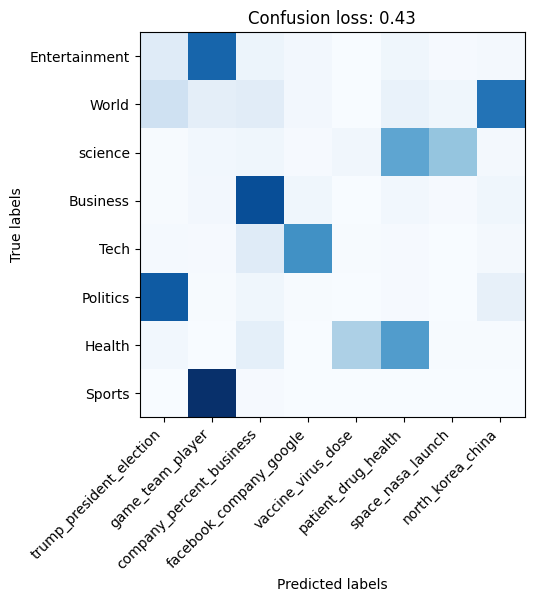

In [4]:
predicted_topics = W.argmax(axis=1)
predicted_topics = [predicted_topic_names[i] for i in predicted_topics]
plot_confusion_loss(labels, predicted_topics, plot_pred_labels=True)


The coherence-score of $0.43$ is not as good as LDA (or BERTopic, as we will see later), but still decent.

## Latent Semantic Analysis

Latent Semantic Analysis (LSA), also known as Latent Semantic Indexing (LSI), again, is a similar technique to LDA and NMF. Like NMF, it works by decomposing a document-term matrix into multiple, interpretable matrices, unveiling latent structure. Hence, it requires the same kind of input data and in turn preprocessing as LDA and NMF.

Unlike NMF, LSA decomposes the document-term matrix into three matricies, $U$, $S$, and $V^T$. $U$ and $V^T$ are orthogonal matrices, and $S$ is a diagonal matrix. The diagonal elements of $S$ are called singular values, and give the *importance* of each topic. The columns of $U$ are called left singular vectors, and the columns of $V^T$ are called right singular vectors. The left singular vectors can be interpreted as document-topic vectors, and the right singular vectors as topic-term vectors.

![](../assets/graphics/lsa.png)

### Training LSA with Sklearn

In [14]:
# We will reuse the tfidf vectorizer from above.
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=8, random_state=42)
W = svd.fit_transform(tfidf)
V = svd.components_
S = svd.singular_values_


### Interpreting LSA Models

We can interpret the topics in the same way as we did for LDA, by looking at the most probable words for each topic.

In [16]:
predicted_topic_names = []

for i, (topic, importance) in enumerate(zip(V, S)):
    print(f"Topic {i} (Importance: {importance:.2f}))")
    print(" ".join([vectorizer.get_feature_names_out()[i]
          for i in topic.argsort()[:-10:-1]]))

    predicted_topic_name = vectorizer.get_feature_names_out()[
        topic.argsort()[:-4:-1]]
    predicted_topic_names.append("_".join(predicted_topic_name))
    print()


Topic 0 (Importance: 10.83))
company year trump new people president like state use

Topic 1 (Importance: 5.93))
trump president election republican vote democrats republicans senate trumps

Topic 2 (Importance: 5.47))
vaccine trump virus health covid patient variant dose president

Topic 3 (Importance: 5.38))
company facebook google app apple amazon tech business technology

Topic 4 (Importance: 4.51))
north korea china missile korean nuclear united kim chinese

Topic 5 (Importance: 4.30))
percent bank billion investor drug price business rate company

Topic 6 (Importance: 4.26))
vaccine korea north china booster dose facebook korean variant

Topic 7 (Importance: 4.04))
space nasa republican launch flight earth astronaut rocket trump



To retrieve the topic for each document, we consider the document-topic matrix $U$. Each row of $U$ is a document-topic vector, and the $i$-th element of the vector is the weight of the $i$-th topic in the document. We can then retrieve the most probable topic for each document by taking the index of the maximum element in the document-topic vector.

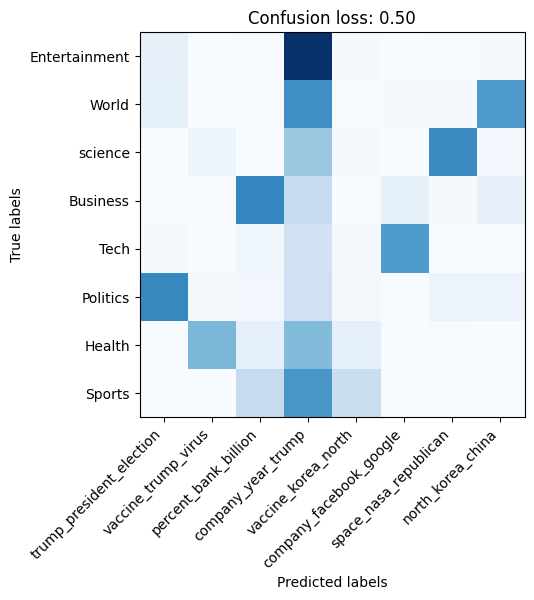

In [20]:
W_ = W / S

predicted_topics = W_.argmax(axis=1)
predicted_topics = [predicted_topic_names[i] for i in predicted_topics]
plot_confusion_loss(labels, predicted_topics, plot_pred_labels=True)


In our case, LSA performs slightly worse than NMF, but still on an acceptable level.